# 0. Install and Import Dependencies

In [ ]:
!pip list

In [1]:
!pip install opencv-python matplotlib imageio gdown tensorflow

You should consider upgrading via the 'r:\projects\lipread\venv\scripts\python.exe -m pip install --upgrade pip' command.



  Using cached tensorflow-2.17.0-cp39-cp39-win_amd64.whl (2.0 kB)
  Using cached numpy-1.26.4-cp39-cp39-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.1
    Uninstalling numpy-2.0.1:
      Successfully uninstalled numpy-2.0.1
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0


In [189]:
from PIL import Image

In [190]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [93]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [2]:
import gdown

In [307]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=34dfdbe7-a9cd-4fd8-8066-464139238b23
To: r:\Projects\LipRead\data.zip
100%|██████████| 423M/423M [00:15<00:00, 27.1MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [308]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [309]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [310]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [311]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [312]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [313]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [314]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [315]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [318]:
test_path = '.\\data\\s1\\bbal9a.mpg'

In [319]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal9a'

In [320]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

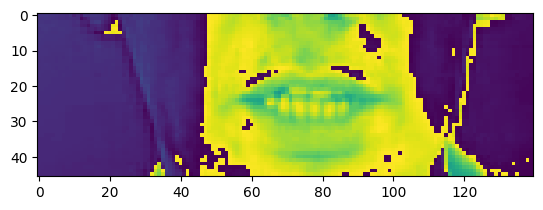

In [321]:
plt.imshow(frames[40])

In [322]:
alignments

<tf.Tensor: shape=(24,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 14,  9, 14,
        5, 39,  1,  7,  1,  9, 14], dtype=int64)>

In [323]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l nine again'>

In [324]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [325]:
from matplotlib import pyplot as plt

In [326]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [327]:
len(test)

50

In [328]:
frames, alignments = data.as_numpy_iterator().next()

In [329]:
len(frames)


2

In [330]:
sample = data.as_numpy_iterator()

In [331]:
val = sample.next(); val[0]

array([[[[[ 1.5482478 ],
          [ 1.4745218 ],
          [ 1.4007957 ],
          ...,
          [ 0.36863044],
          [ 0.3317674 ],
          [ 0.3317674 ]],

         [[ 1.621974  ],
          [ 1.2533435 ],
          [ 1.2902066 ],
          ...,
          [ 0.36863044],
          [ 0.3317674 ],
          [ 0.3317674 ]],

         [[ 1.5113848 ],
          [ 1.5113848 ],
          [ 1.5113848 ],
          ...,
          [ 0.3317674 ],
          [ 0.3317674 ],
          [ 0.3317674 ]],

         ...,

         [[ 1.1058913 ],
          [ 1.0690283 ],
          [ 1.0690283 ],
          ...,
          [ 0.07372609],
          [ 0.07372609],
          [ 0.07372609]],

         [[ 1.0690283 ],
          [ 1.0690283 ],
          [ 1.0690283 ],
          ...,
          [ 0.07372609],
          [ 0.07372609],
          [ 0.07372609]],

         [[ 1.0690283 ],
          [ 1.0690283 ],
          [ 1.0690283 ],
          ...,
          [ 0.07372609],
          [ 0.07372609],
          

In [332]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

TypeError: Cannot handle this data type: (1, 1, 1), <f4

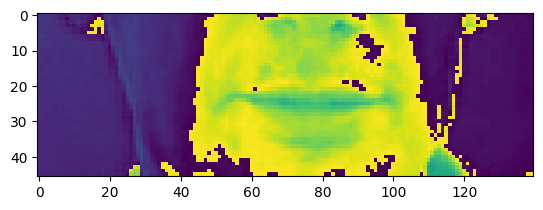

In [333]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [335]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin white at t three soon'>

# 3. Design the Deep Neural Network

In [336]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [337]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [338]:
# Define the model
model = Sequential()

# 3D Convolutional layers
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

# TimeDistributed Flatten
model.add(TimeDistributed(Flatten()))

# Explicit Reshape to ensure the correct shape for LSTM layers
# Here we reshape the output into the shape (batch_size, time_steps, features)
model.add(Reshape((75, -1)))  # The second dimension (time_steps) is 75, and features will be inferred

# Bidirectional LSTM layers
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

# Final Dense layer for classification
model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))

# Print the model summary to check the architecture
model.summary()

r:\Projects\LipRead\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_30 (Conv3D)              │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_30 (MaxPooling3D) │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_31 (Conv3D)              │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_31 (MaxPooling3D) │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_32 (Conv3D)              │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_32 (MaxPooling3D) │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 75, 6375)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, 75, 256)        │     6,660,096 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 75, 256)        │       394,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [339]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_30 (Conv3D)              │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_30 (MaxPooling3D) │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_31 (Conv3D)              │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_31 (MaxPooling3D) │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_32 (Conv3D)              │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_32 (MaxPooling3D) │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 75, 6375)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, 75, 256)        │     6,660,096 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 75, 256)        │       394,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [275]:
5*17*75

6375

In [340]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [341]:
print(yhat)

[[[0.02766995 0.02235525 0.0220496  ... 0.02891948 0.02495668 0.01617368]
  [0.02785921 0.02165671 0.02186304 ... 0.0304086  0.0242239  0.01583613]
  [0.02778609 0.02113333 0.02168104 ... 0.03205219 0.02354621 0.01572287]
  ...
  [0.0213724  0.02229419 0.02267781 ... 0.03191648 0.01924817 0.02387234]
  [0.02115944 0.02244759 0.02282984 ... 0.03081809 0.01914023 0.02572414]
  [0.02107717 0.02256557 0.02278717 ... 0.02962691 0.01918077 0.02769414]]

 [[0.02967098 0.02404506 0.01994063 ... 0.02916347 0.02691696 0.01632981]
  [0.02995385 0.02365431 0.01972104 ... 0.03042526 0.02597202 0.01610176]
  [0.02999039 0.02336373 0.01952002 ... 0.03174709 0.02502212 0.01617243]
  ...
  [0.02218954 0.02338122 0.02002919 ... 0.03409498 0.01684863 0.02834726]
  [0.02173426 0.02317814 0.02064153 ... 0.03239355 0.01680449 0.03053783]
  [0.02178427 0.02297284 0.02143666 ... 0.03020629 0.01704585 0.03282785]]]


In [342]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'uuuuuu999999999999999999999999ggggggggggggggggggggggggggg999999999999999ggg'>

In [343]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'uuuuuu999999999999999999999999ggggggggggggggggggggggggggg999999999999999ggg'>

In [344]:
model.input_shape

(None, 75, 46, 140, 1)

In [345]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [346]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [347]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [348]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [349]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [350]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True) 

In [351]:
schedule_callback = LearningRateScheduler(scheduler)

In [352]:
example_callback = ProduceExample(test)

In [353]:
model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback, example_callback])

InvalidArgumentError: Graph execution error:

Detected at node sequential_10_1/time_distributed_10_1/Reshape_7 defined at (most recent call last):
  File "C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main

  File "C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code

  File "r:\Projects\LipRead\venv\lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "r:\Projects\LipRead\venv\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "r:\Projects\LipRead\venv\lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "r:\Projects\LipRead\venv\lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 596, in run_forever

  File "C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1890, in _run_once

  File "C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run

  File "r:\Projects\LipRead\venv\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "r:\Projects\LipRead\venv\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "r:\Projects\LipRead\venv\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "r:\Projects\LipRead\venv\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "r:\Projects\LipRead\venv\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "r:\Projects\LipRead\venv\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "r:\Projects\LipRead\venv\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "r:\Projects\LipRead\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell

  File "r:\Projects\LipRead\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell

  File "r:\Projects\LipRead\venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "r:\Projects\LipRead\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async

  File "r:\Projects\LipRead\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes

  File "r:\Projects\LipRead\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code

  File "C:\Users\USER\AppData\Local\Temp\ipykernel_25708\289372373.py", line 1, in <module>

  File "r:\Projects\LipRead\venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "r:\Projects\LipRead\venv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit

  File "r:\Projects\LipRead\venv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "r:\Projects\LipRead\venv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "r:\Projects\LipRead\venv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 51, in train_step

  File "r:\Projects\LipRead\venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "r:\Projects\LipRead\venv\lib\site-packages\keras\src\layers\layer.py", line 901, in __call__

  File "r:\Projects\LipRead\venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "r:\Projects\LipRead\venv\lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "r:\Projects\LipRead\venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "r:\Projects\LipRead\venv\lib\site-packages\keras\src\models\sequential.py", line 212, in call

  File "r:\Projects\LipRead\venv\lib\site-packages\keras\src\models\functional.py", line 175, in call

  File "r:\Projects\LipRead\venv\lib\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "r:\Projects\LipRead\venv\lib\site-packages\keras\src\models\functional.py", line 560, in call

  File "r:\Projects\LipRead\venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "r:\Projects\LipRead\venv\lib\site-packages\keras\src\layers\layer.py", line 901, in __call__

  File "r:\Projects\LipRead\venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "r:\Projects\LipRead\venv\lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "r:\Projects\LipRead\venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "r:\Projects\LipRead\venv\lib\site-packages\keras\src\layers\rnn\time_distributed.py", line 108, in call

  File "r:\Projects\LipRead\venv\lib\site-packages\keras\src\layers\rnn\time_distributed.py", line 108, in <listcomp>

  File "r:\Projects\LipRead\venv\lib\site-packages\keras\src\layers\rnn\time_distributed.py", line 102, in step_function

  File "r:\Projects\LipRead\venv\lib\site-packages\keras\src\layers\reshaping\flatten.py", line 54, in call

  File "r:\Projects\LipRead\venv\lib\site-packages\keras\src\ops\numpy.py", line 4440, in reshape

  File "r:\Projects\LipRead\venv\lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 1789, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node sequential_10_1/time_distributed_10_1/Reshape_7}}]] [Op:__inference_one_step_on_iterator_3391260]

# 5. Make a Prediction 

In [81]:
import gdown

In [13]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=3fe837b3-e0eb-408a-ba2b-d75205876d9a
To: r:\Projects\LipRead\checkpoints.zip
100%|██████████| 94.5M/94.5M [00:09<00:00, 10.2MB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [354]:
model.save_weights('models/checkpoint.weights.h5')

In [355]:
model.load_weights('R:/Projects/LipRead/models/checkpoint.weights.h5')

In [356]:
test_data = test.as_numpy_iterator()

In [357]:
sample = test_data.next()

In [358]:
yhat = model.predict(sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [359]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set blue in m eight now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in q three again'>]

In [360]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75, 75], greedy=False, beam_width=10)[0][0].numpy()

In [361]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b"r1r1'1'1'1c191919131r1r1r1r1r1r13r3g">,
 <tf.Tensor: shape=(), dtype=string, numpy=b'rkr9r9r9r9r9r9r9r9r9r9r9r9r9k9k9k9gn'>]

In [252]:
# Print the real text
print('~' * 100, 'REAL TEXT')
real_text = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]
print(real_text)

# Print the model's output before decoding
print('~' * 100, 'MODEL OUTPUT')
print(yhat)

# Decode the predictions
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75, 75], greedy=True)[0][0].numpy()

# Print the predictions
print('~' * 100, 'PREDICTIONS')
predictions = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]
print(predictions)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT
[<tf.Tensor: shape=(), dtype=string, numpy=b'lay white in e seven again'>, <tf.Tensor: shape=(), dtype=string, numpy=b'place red with k one again'>]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ MODEL OUTPUT
[[[0.01713581 0.02264203 0.0265773  ... 0.02879377 0.02404393 0.02352787]
  [0.01792792 0.02268917 0.02783038 ... 0.03035702 0.02410335 0.02442565]
  [0.01846183 0.02287548 0.02876303 ... 0.03115546 0.0239373  0.02533168]
  ...
  [0.02091498 0.02654994 0.02867388 ... 0.02571102 0.01769179 0.0308936 ]
  [0.02179109 0.0261689  0.0281531  ... 0.02540006 0.01804717 0.02967253]
  [0.02226149 0.02492983 0.02727981 ... 0.02450635 0.01876806 0.02857396]]

 [[0.01747822 0.02082173 0.02440189 ... 0.02623565 0.0221274  0.02589737]
  [0.01820022 0.02068708 0.02535008 ... 0.02704383 0.02185441 0.02711239]
  [0.01865688 0.02066493 0

# Test on a Video

In [254]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [255]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [256]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [257]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [258]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'f3r3'>]